In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
%matplotlib inline

In [32]:
df = pd.read_csv("A2_data.csv")

In [33]:
# unique classes
print(df['class'].unique())

labels = df['class']
# drop the class column
df = df.drop(['class','field_ID','plate'], axis=1)



['GALAXY' 'QSO' 'STAR']


In [81]:
df.head()

,alpha,delta,u,g,r,i,z,MJD,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,56064,-0.001584
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,53727,-0.824700
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,54883,-0.418000
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,51783,5.953000
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,56069,0.846000


PCA

In [34]:
# apply PCA

scaler = StandardScaler()

pca = PCA(n_components=2)
scaled = scaler.fit_transform(df)



# pca.fit(scaled)


transformed = pca.fit_transform(scaled)

In [37]:
transformed_pca = pd.DataFrame(transformed, columns=['PC1', 'PC2'])
key=transformed_pca.keys()
transformed_pca

,PC1,PC2
0,-0.109961,0.315134
1,-0.400117,1.933508
2,-0.167440,0.462536
3,-0.234969,1.256382
4,0.473993,-2.470300
...,...,...
99995,-0.308837,1.796653
99996,-0.139276,0.617743
99997,0.207217,-1.102240
99998,-0.095390,0.051758


Random Forest Classifier

In [38]:
#split the dataset
x_train, x_test, y_train, y_test = train_test_split(transformed_pca, labels, test_size=0.3, random_state=123, stratify=labels)
clf = RandomForestClassifier()

In [44]:
#scale the data to speed up Random Forest
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train_scaled = scaling.transform(x_train)
x_test_scaled = scaling.transform(x_test)

Hyperparameter Optimisation

In [38]:
#Parameters of RandomForest
pprint(clf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [45]:
#tuning using Random Search
hyperparameters = {'max_features':[None, 'auto', 'sqrt', 'log2'],
                   'max_depth':[None, 1, 5, 10, 15, 20],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5, 10],
                   'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
                   'criterion': ['gini', 'entropy']}
rf_random = RandomizedSearchCV(clf, hyperparameters, n_iter = 50, cv = 5, verbose=2, random_state=123, n_jobs = -1)
rf_random.fit(x_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\KYRIAKOS ARISTIDOU\anaconda3\envs\deeplearning\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(criterion='entropy',
                                                    max_features=None,
                                                    n_estimators=80),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 1, 5, 10, 15, 20],
                                        'max_features': [None, 'auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=123, verbose=2)

In [46]:
rf_random.best_params_

{'n_estimators': 70,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 15,
 'criterion': 'entropy'}

Cross Validation Score

In [17]:
# from sklearn.model_selection import cross_val_score

# cross_score = cross_val_score(clf,features,labels,cv = 5,scoring = "accuracy")
# print(f' Scores for each fold are: {cross_score}')
# print(f' Average score: {"{:.2f}".format(cross_score.mean())}')

Training the RandomForest

In [47]:
clf.set_params(criterion = 'entropy', max_features = 'auto', max_depth = 15, min_samples_leaf = 2, min_samples_split = 10, n_estimators = 70)

RandomForestClassifier(criterion='entropy', max_depth=15, max_features='auto',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=70)

Test and Evaluation

In [48]:
from sklearn.metrics import accuracy_score, f1_score

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_

c:\Users\KYRIAKOS ARISTIDOU\anaconda3\envs\deeplearning\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [49]:
print('features importances are : ' , clf.feature_importances_)

features importances are :  [0.48764671 0.51235329]


<BarContainer object of 2 artists>

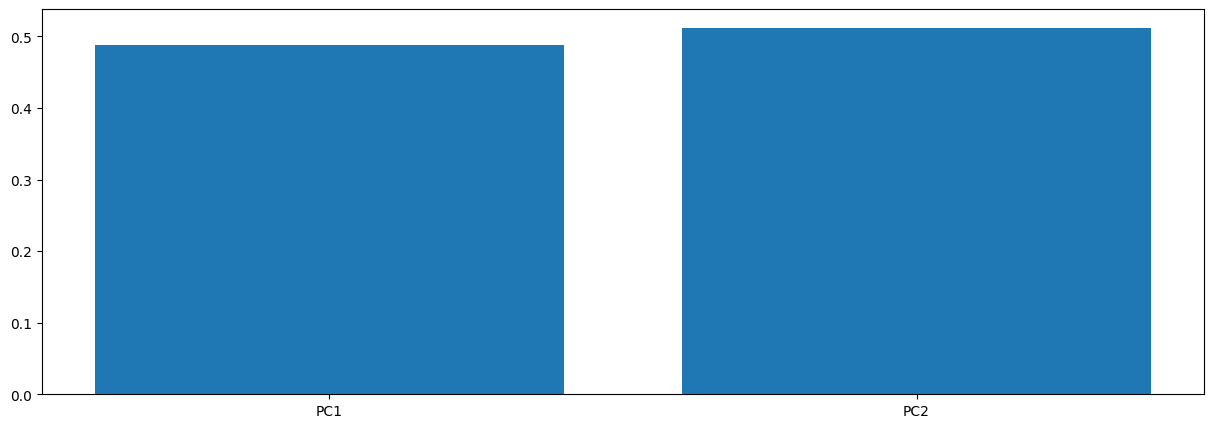

In [50]:
#Visualize feature importance

plt.figure(figsize=(15,5))
plt.bar(key,clf.feature_importances_)

In [51]:
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_


Classification report and confusion matrix

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(cm)

              precision    recall  f1-score   support

      GALAXY       0.77      0.90      0.83     17834
         QSO       0.70      0.72      0.71      5688
        STAR       0.61      0.31      0.41      6478

    accuracy                           0.74     30000
   macro avg       0.69      0.64      0.65     30000
weighted avg       0.72      0.74      0.72     30000

[[16104   866   864]
 [ 1209  4096   383]
 [ 3562   929  1987]]


Visualization of Confusion Matrix

Text(43.25, 0.5, 'True')

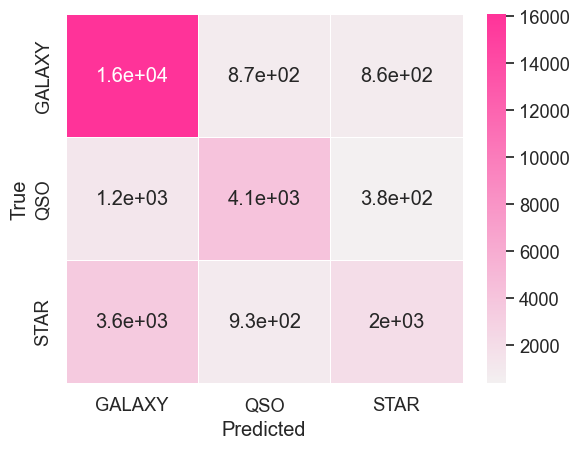

In [53]:
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.2)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')